In [2]:
import numpy as np
import matplotlib.pyplot as mpl

Assigning values to the parameters:

In [3]:
# K+ concentrations :
Ki = 0.15 # M, inside
Krest = 0.0035 # Resting Ko. M., outside

R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature
GKmax = 1e-4 #1/10MOhm. A Guess. Needs a big prefactor?
Cm =3e-10 # f # to refine ? 0.1 uF?
Gl = 0.1e-7 # Leak conductance of 1/10MOhm.
El = -0.05 # V resting potential of the leak

#pump coefficient ?

# For now work in concentrations rather than quantities.
Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.001 # M change in Ko with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals.
times = np.arange(0,2,1e-6)
Km = 0.002 # M the affinity of the ATPase Na+/K+ for K+
Vmax = 0.02 # M s-1 vitesse max ATPase

Djuxta = 1.9*1e-6 #Length of the nodal gap ? example value in m
DK =1.85*1e-9 # coef de diffusion

# 1st model : only looking at submylein/myelin compartment


## 1) Modelisation of K+ extracellular concentration

### Function to mimick the influx of K+ in the myelin during succesion of APs in the axon :
- It's gonna add APefflux to the concentration if we are at a time t where there is a new AP (known by APtimes)
- It's gonna remove the amount of K+ that is imported inside the cell by the ATPase NA+/K+

I have change t, t+dt into t-dt, t


In [4]:
def dK(t,Ko,dt=dt):
    # Tedious calculation to add K efflux at correct time steps.
    d = 0
    if sum(APtimes < (t-dt)) < sum(APtimes < t): #meaning that the t+dt is reaching the timing of a new AP
        d += APefflux # addition of K+ efflux from the neuronal activity
    d -= dt*Vmax*(Ko - Krest)/(Km + (Ko - Krest)) #we also decrease d with the ATPase activity that takes K+ ions inside the cell ( Michaelis-Menten model)
    return d


### Function to generate the evolution of extracellular [K+] upon time:

In [5]:
def Kintegrate(times, Krest=Krest):
    K = np.full(len(times), Krest) #initialisation at the resting concentration of K+
    for i in np.arange(1, len(times)):
        K[i] = K[i-1] + dK(times[i], K[i-1]) #at each time points, we add to the concentration the change dK, that is calculated based on the concentration and the time
    return K

**Model 1 : Only K+ AP efflux and ATPase Na+/K+**

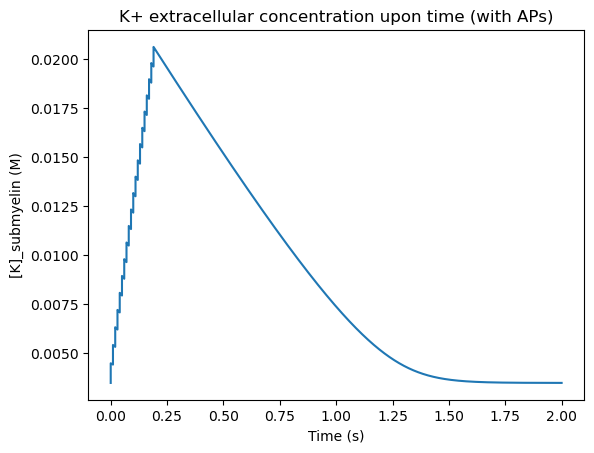

In [13]:
K = Kintegrate(times)
mpl.plot(times, K)
mpl.xlabel("Time (s)")
mpl.ylabel("[K]_submyelin (M)")
mpl.title("K+ extracellular concentration upon time (with APs)")
mpl.show()

I tried to use the FIck Law to model the diffusion of K+ in the sub region. I consider that my two compartment were the paranodal region and the nodal region. They are separated by the distance of the myelin attachement sheat. I consider that at the node, the K+ concentration is the Krest (since it is diluting very fast because the volume of the compartment is big at that place).

In [8]:
def Fick(K,Krest):
    flux=-DK*(K-Krest)/Djuxta #Formula of Fick Law
    K+=flux
    return K



In [17]:
Kfick=K
for i in range(len(Kfick)):
    Kfick[i]=Fick(Kfick[i],Krest)

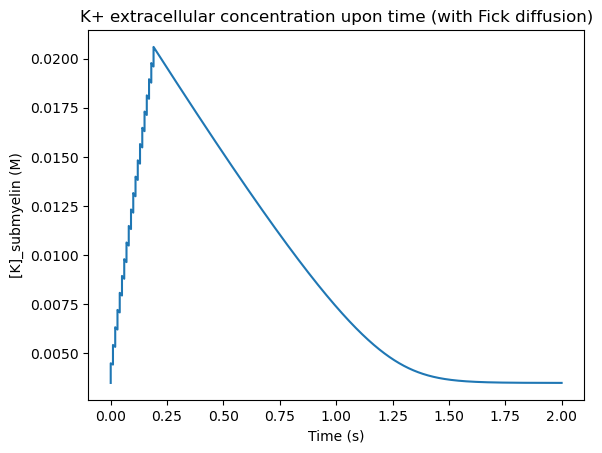

In [18]:
mpl.plot(times, Kfick)
mpl.xlabel("Time (s)")
mpl.ylabel("[K]_submyelin (M)")
mpl.title("K+ extracellular concentration upon time (with Fick diffusion)")
mpl.show()

I don't see any difference now that i have put the Djuxta as the distance intranode.

## 2) Modelisation of the voltage of the myelin

If we consider there is no additional K+ current with a specific channel involved, what would be the voltage ?
We could use GHK equation, but simplify it by only considering K+ ions ?
**=> NO here i am looking at the cell like if there was a leak channel only for K+ because i am looking at Ek**

In [19]:
Vm = np.full(len(times), 0,dtype=float)
for i in range (0,len(times)):
    Vm[i] = (R*T/F*np.log(K[i]/Ki))
Vm=Vm*1000


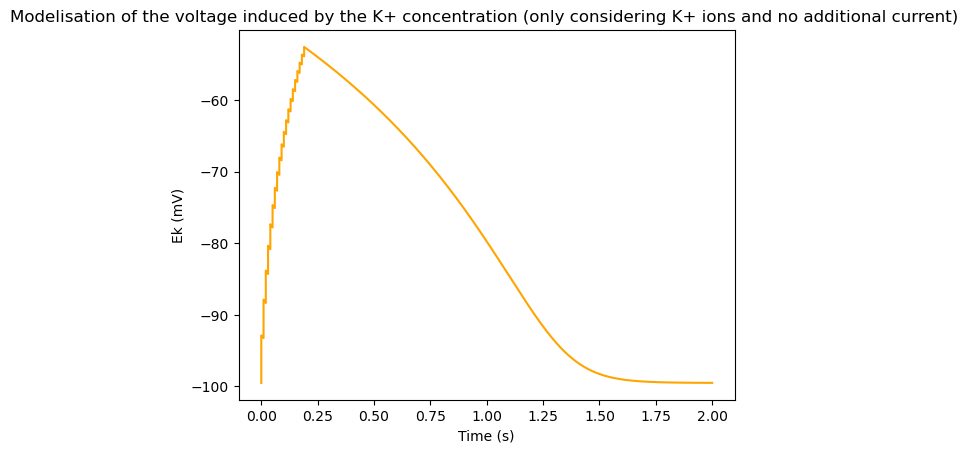

In [20]:
fig,ax=mpl.subplots()
mpl.plot(times, Vm,color='orange')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Ek (mV)")
mpl.title('Modelisation of the voltage induced by the K+ concentration (only considering K+ ions and no additional current) ')
mpl.show()

==> This gives an idea of th tendency of the change : indeed we are gonna have a depolarisation that then comes bck to normal, but it is not granted that there is nothing at all. If there was no current for K+, then the change in concentration would not change anything.

### Function to calculate current through inward rectifier.
Using the formulation of https://link.springer.com/article/10.1007/BF01870103
D(elta)V = V - EK
gK = A/[1 + exp((DV + 15mV)/7mV)]*np.sqrt(Ko)
We can probably just assume the steady-state conductance and neglect any transient regimes.


**TO DO: use activities?**

In [63]:
# V volts, Ko molar.
def I_KIR(V, Ko):
    EK = (R*T/F*np.log(Ko/Ki)) #calculating the Equilibrium potential for K+ with Nernst Law
    DV = V - EK #driving force in V
    return DV*GKmax/(1 + np.exp((DV+0.015)/0.007))*np.sqrt(Ko)

Plotting the IV curve :

In [22]:
V = np.arange(-0.120,0.040,0.002, dtype=float) #in Volts
def I_curve( V,Krest):
    I = np.zeros(len(V))
    for i in np.arange(0, len(V)):
        I[i]= I_KIR(V[i], Krest)
    return I


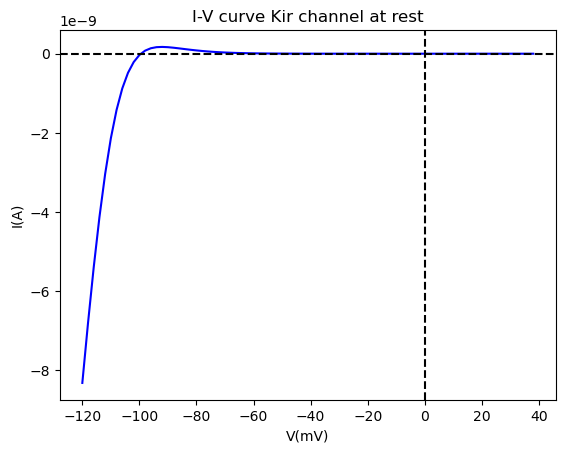

In [23]:
fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V*1000, Icurve,'blue',label='Ko~0.0035M (Krest)')
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.title("I-V curve Kir channel at rest")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

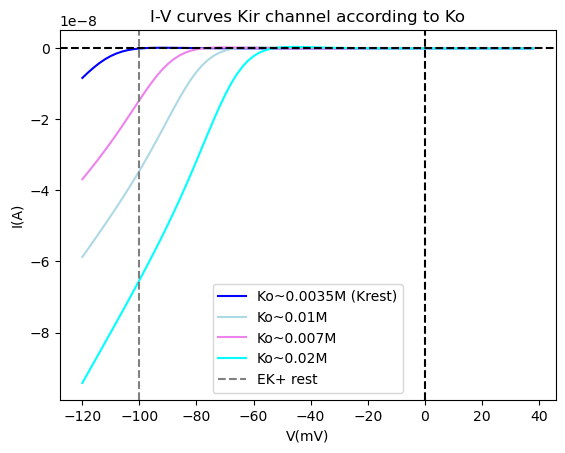

In [24]:

fig,ax=mpl.subplots()
Icurve = I_curve( V,Krest)
mpl.plot(V*1000, Icurve,'blue',label='Ko~0.0035M (Krest)')
Icurve2=I_curve( V,K[100000])
mpl.plot(V*1000, Icurve2,'lightblue',label='Ko~0.01M')
Icurve3=I_curve( V,K[50000])
mpl.plot(V*1000, Icurve3,'violet',label='Ko~0.007M')
Icurve4=I_curve( V,0.02)
mpl.plot(V*1000, Icurve4,'cyan',label='Ko~0.02M')
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.axvline(x=-100,color='grey',linestyle='--',label='EK+ rest')
mpl.title("I-V curves Kir channel according to Ko")
ax.legend()
mpl.show()

--> The Eeq of the channel is going to change according to the outside K+ concentration. When it is  high, there is more inward K+ current at the same voltage of the membrane. This is gonna pull the cell back to the resting situation, with influx of K+ directing  the K+ extracellular concentration back to resting value.

In [25]:
def Ileak(V):
    return Gl*(V-El)

In [26]:
V = np.arange(-0.120,0.040,0.002, dtype=float)
def Ileak_curve( V):
    I = np.zeros(len(V))
    for i in np.arange(0, len(V)):
        I[i]= Ileak(V[i])
    return I

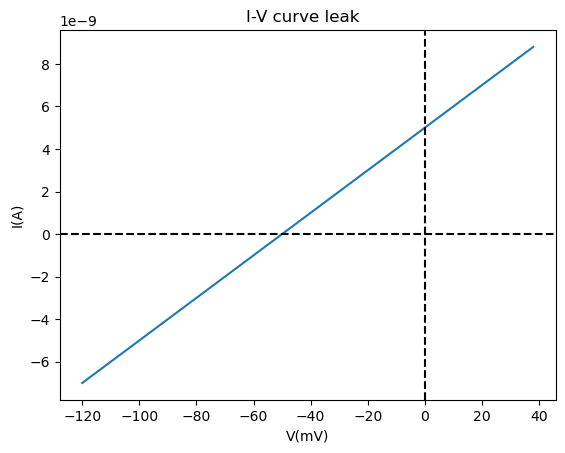

In [27]:
fig,ax=mpl.subplots()
Icurve = Ileak_curve( V)
mpl.plot(V*1000, Icurve)
ax.set_xlabel("V(mV)")
ax.set_ylabel("I(A)")
mpl.title("I-V curve leak  ")
mpl.axhline(y=0, color='k',linestyle='--')
mpl.axvline(x=0, color='k',linestyle='--')
mpl.show()

### I upon Ko at the resting potential (El=-50mV)
I am looking at the plot I upon  Ko, at a given V (El). It might don't be pertinent since the V is changing with KO changing.

In [64]:
I_KO = I_KIR(np.full(len(K),-0.05),K) #here i try V as the El

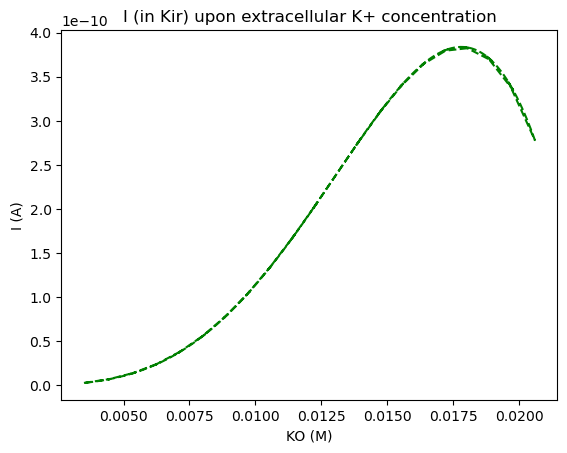

In [65]:
fig,ax=mpl.subplots()
mpl.plot(K, I_KO, color='green',linestyle='--')
ax.set_xlabel("KO (M)")
ax.set_ylabel("I (A)")
mpl.title('I (in Kir) upon extracellular K+ concentration')
mpl.show()

-> We have a positive current, but we expect inward current.

### Integrating the current through the Kir into change in voltage

**Test 3:**
With Im= Ikir+ Icapactive + Ileak = 0
/!\ the formula for Ikir (but the I_KIR function) is not in the same convention, here we consider the I all going from the intracellular to the submylein region
V(t+dt)=V(t) - dt/Cm * (-Ikir + Gl(V(t)-El))


In [66]:
def Vintegrate(times,Ko,El):
    V = np.full(len(times), El) #Initialisation so that the V[0] is El (with conversion in mV)
    for i in np.arange(0, len(times)-1):
        V[i+1]= V[i]- dt/Cm *(-I_KIR(V[i],Ko[i])+Gl*(V[i]-El))
    return V

In [99]:
V = Vintegrate(times,K,El)
V

array([-0.05      , -0.04999991, -0.04999969, ..., -0.04974276,
       -0.04974276, -0.04974276], shape=(2000000,))

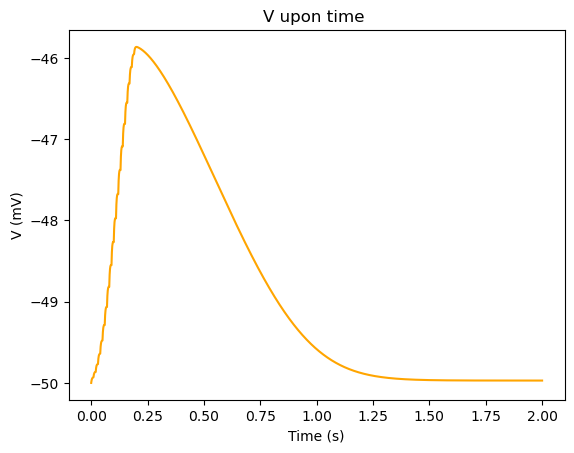

In [71]:
fig,ax=mpl.subplots()
mpl.plot(times, V*1000,color='orange')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time ")
mpl.show()

=> We are close to the good dynamics, but it seems that in the article the value of V change are higher

### Changing Gmax of Kir

In [105]:
GKmax_test = np.arange(1e-5,1e-3,(1e-3-1e-5)/10)

In [101]:
V=np.full((len(GKmax_test),len(times)),0.)
print(np.shape(V))

(10, 2000000)


In [106]:

for i in range(len(GKmax_test)):
    GKmax=GKmax_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[[-0.05       -0.04999999 -0.04999997 ... -0.04997093 -0.04997093
  -0.04997093]
 [-0.05       -0.04999989 -0.04999963 ... -0.04969373 -0.04969373
  -0.04969373]
 [-0.05       -0.0499998  -0.04999929 ... -0.04943392 -0.04943392
  -0.04943392]
 ...
 [-0.05       -0.04999932 -0.04999759 ... -0.04832987 -0.04832987
  -0.04832987]
 [-0.05       -0.04999922 -0.04999725 ... -0.048139   -0.048139
  -0.048139  ]
 [-0.05       -0.04999912 -0.04999691 ... -0.04795597 -0.04795597
  -0.04795597]]


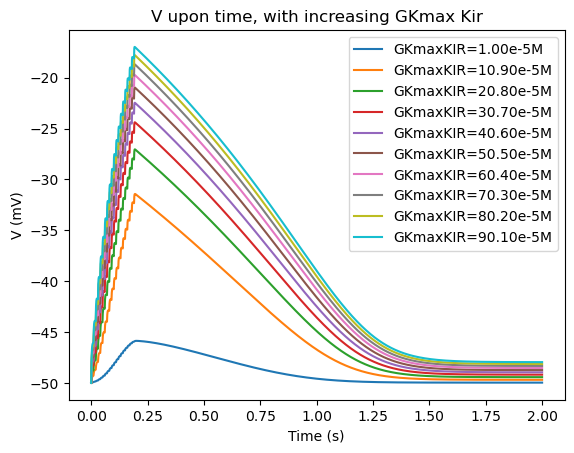

In [114]:

fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'GKmaxKIR={GKmax_test[i]*1e5:.2f}e-5M')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with increasing GKmax Kir")
mpl.legend()
mpl.show()

-> The GKMAX factor is gonna influence drastically the amplitude of the deploarisation of the myelin.

### Changing Cm

with GKmax being 1e-4

In [138]:
Cm_test=np.arange(Cm,1e-7,(1e-7-Cm)/10)
print(Cm_test)

[3.000e-10 1.027e-08 2.024e-08 3.021e-08 4.018e-08 5.015e-08 6.012e-08
 7.009e-08 8.006e-08 9.003e-08]


In [149]:
V=np.full((len(Cm_test),len(times)),0.)


In [150]:
for i in range(len(Cm_test)):
    Cm=Cm_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[[-0.05       -0.0499999  -0.04999966 ... -0.04971818 -0.04971818
  -0.04971818]
 [-0.05       -0.05       -0.04999999 ... -0.04971542 -0.04971542
  -0.04971542]
 [-0.05       -0.05       -0.04999999 ... -0.04966091 -0.04966091
  -0.04966091]
 ...
 [-0.05       -0.05       -0.05       ... -0.04774009 -0.04774009
  -0.04774009]
 [-0.05       -0.05       -0.05       ... -0.04733692 -0.04733692
  -0.04733693]
 [-0.05       -0.05       -0.05       ... -0.04698796 -0.04698797
  -0.04698797]]


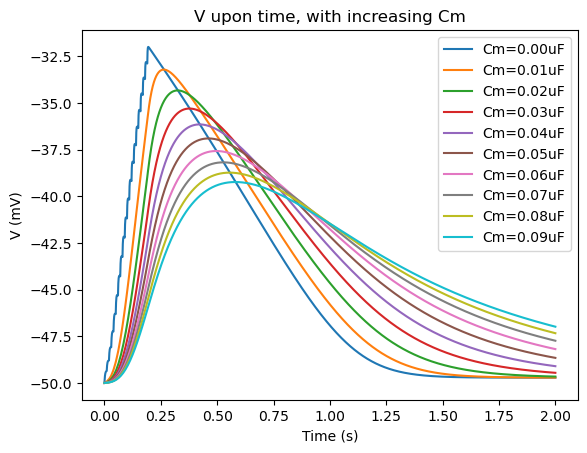

In [151]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Cm={Cm_test[i]*1e6:.2f}uF')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with increasing Cm")
mpl.legend()
mpl.show()

-> the capacitance of the myelin is gonna influence the timing of the maximum of the depolarisation
It seems that in the article, the depolarisation is quite fast, indicating a pretty low capacitance.

### Changing Gl

with GKmax being 1e-4M, and Cm being 3e-10F

In [143]:
Gl_test=np.arange(1e-8,1e-6,(1e-6-1e-8)/10)

In [144]:
V=np.full((len(Gl_test),len(times)),0.)

In [145]:
for i in range(len(Gl_test)):
    Gl=Gl_test[i]
    V[i] = Vintegrate(times, K, El)
print(V)

[[-0.05       -0.0499999  -0.04999966 ... -0.04777946 -0.04777946
  -0.04777946]
 [-0.05       -0.0499999  -0.04999966 ... -0.04974073 -0.04974073
  -0.04974073]
 [-0.05       -0.0499999  -0.04999966 ... -0.0498621  -0.0498621
  -0.0498621 ]
 ...
 [-0.05       -0.0499999  -0.04999966 ... -0.04995871 -0.04995871
  -0.04995871]
 [-0.05       -0.0499999  -0.04999966 ... -0.04996379 -0.04996379
  -0.04996379]
 [-0.05       -0.0499999  -0.04999966 ... -0.04996775 -0.04996775
  -0.04996775]]


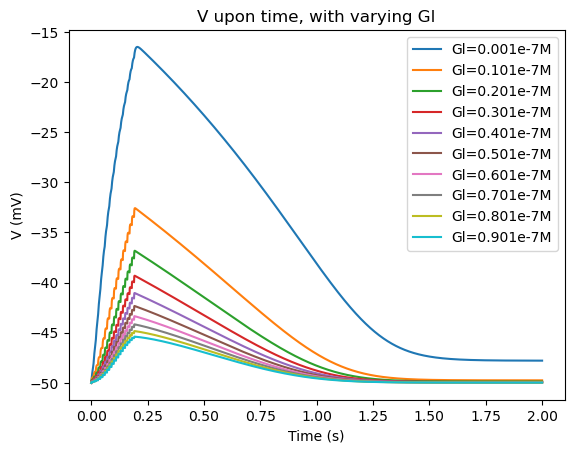

In [147]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Gl={Cm_test[i]*1e7:.2f}1e-7M')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with varying Gl")
mpl.legend()
mpl.show()

-> The leaking conductance influences the amplitude of the depolarisation as expected. Lower leakage leads to stronger depolarisation.

with GKmax being 1e-4M, and Cm being 3e-10F, Gl being 0.1E-7


In [155]:
Vmax_test=np.arange(0.01,0.05,0.01)


In [156]:
K_test=np.full((len(Vmax_test),len(times)),0.)


In [158]:
for i in range(len(Vmax_test)):
    Vmax=Vmax_test[i]
    K_test[i] = Kintegrate(times, Krest)


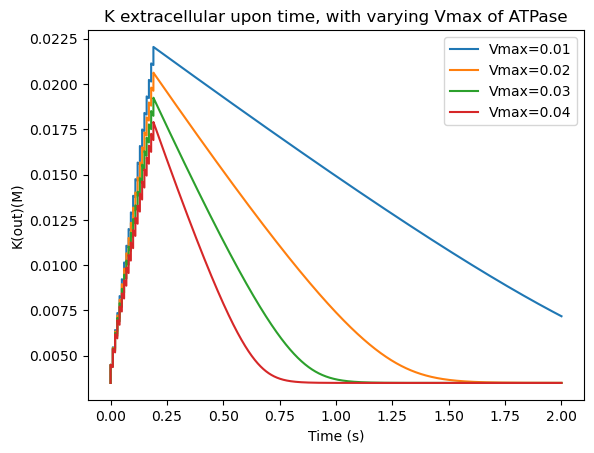

In [159]:
fig, ax = mpl.subplots()
for i in range (len(K_test)):
    mpl.plot(times, K_test[i] , label=f'Vmax={Vmax_test[i]:.2f}')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K(out)(M)")
mpl.title("K extracellular upon time, with varying Vmax of ATPase")
mpl.legend()
mpl.show()

In [160]:
V=np.full((len(K_test),len(times)),0.)

In [161]:
for i in range(len(K_test)):
    V[i] = Vintegrate(times, K_test[i], El)

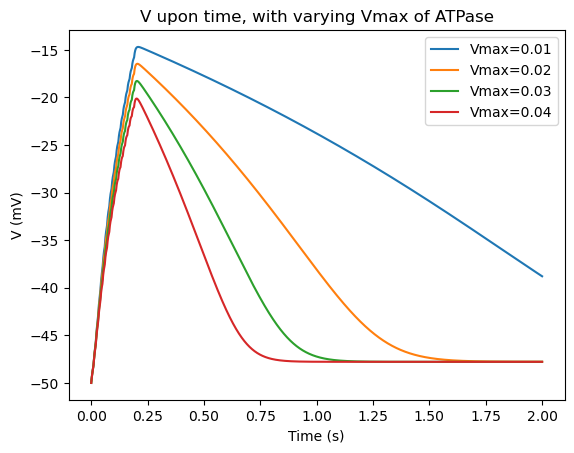

In [162]:
fig, ax = mpl.subplots()
for i in range (len(V)):
    mpl.plot(times, V[i] * 1000, label=f'Vmax={Vmax_test[i]:.2f}')
ax.set_xlabel("Time (s)")
ax.set_ylabel("V (mV)")
mpl.title("V upon time, with varying Vmax of ATPase")
mpl.legend()
mpl.show()

-> it influences the "tau" of the repolarisation, not so much the amplitude, neither the timing of max depolarisation.

**=> So what really matters is the ratio between GL and GKmax, that will dictate the amplitude of the depolarisation. The capacitance is quite low.**

# 2nd model : with compartments

In [9]:
# K+ concentrations :
Ki = 0.15 # M, inside
Krest = 0.0035 # Resting Ko. M., outside


# Leak conductances
Glmysubmy=Gl
Glmyext=Gl = 0.01e-7 #10X lower than Glmysubmy


R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature
GKmax = 1e-4 #1/10MOhm. A Guess. Needs a big prefactor?
Cm =3e-10 # f # to refine ? 0.1 uF? of the myelin
El = -0.05 # V resting potential of the leak

#pump coefficient ?

# For now work in concentrations rather than quantities.
Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.001 # M change in Ko with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals.
times = np.arange(0,2,1e-6)
Km = 0.002 # M the affinity of the ATPase Na+/K+ for K+
Vmax = 0.02 # M s-1 vitesse max ATPase

Djuxta = 1.9*1e-6 #Length of the nodal gap ? example value in m
DK =1.85*1e-9 # coef de diffusion

In [10]:
axonK=np.full(len(times),Ki)
submyelinK=np.full(len(times),Krest)
myelinK=np.full(len(times),Ki)
extK=np.full(len(times),Krest)

In [ ]:
submyelinK=